# Organize ML projects with Scikit-Learn

While Machine Learning is powerful, people often overestimate it: apply machine learning to your project, and all your problems will be solved. In reality, it's not this simple. To be effective, one needs to organize the work very well. In this notebook, we will walkthrough practical aspects of a ML project. To look at the big picture, let's start with a checklist below. It should work reasonably well for most ML projects, but make sure to adapt it to your needs:

1. **Define the scope of work and objective**
    * How is your solution be used?
    * How should performance be measured? Are there any contraints?
    * How would the problem be solved manually?
    * List the available assumptions, and verify if possible.
    
    
2. **Get the data**
    * Document where you can get that data
    * Store data in a workspace you can easily access
    * Convert the data to a format you can easily manipulate
    * Check the overview (size, type, sample, description, statistics)
    * Data cleaning
    
    
3. **EDA & Data transformation**
    * Study each attribute and its characteristics (missing values, type of distribution, usefulness)
    * Visualize the data
    * Study the correlations between attributes
    * Feature selection, Feature Engineering, Feature scaling
    * Write functions for all data transformations
    
    
4. **Train models**
    * Automate as much as possible
    * Train promising models quickly using standard parameters. Measure and compare their performance
    * Analyze the errors the models make
    * Shortlist the top three of five most promising models, preferring models that make different types of errors.


5. **Fine-tunning**
    * Treat data transformation choices as hyperparameters, expecially when you are not sure about them (e.g., replace missing values with zeros or with the median value)
    * Unless there are very few hyperparameter value to explore, prefer random search over grid search.
    * Try ensemble methods
    * Test your final model on the test set to estimate the generalizaiton error. Don't tweak your model again, you would start overfitting the test set.

## Example: Articles categorization

### Objectives

Build a model to determine the categories of articles. 

### Get Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
bbc = pd.read_csv('https://raw.githubusercontent.com/dhminh1024/practice_datasets/master/bbc-text.csv')

In [3]:
bbc.head(5)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
bbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [5]:
print(f"Shape : {bbc.shape}, \n\nColumns: {bbc.columns}, \n\nCategories: {bbc.category.unique()}")

# print sample data
bbc.head().append(bbc.tail())

Shape : (2225, 2), 

Columns: Index(['category', 'text'], dtype='object'), 

Categories: ['tech' 'business' 'sport' 'entertainment' 'politics']


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...
2224,sport,souness delight at euro progress boss graeme s...


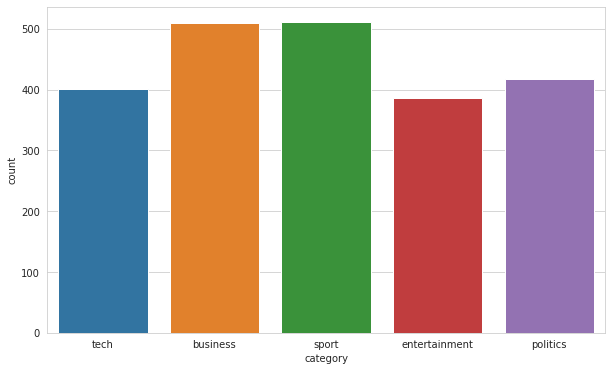

In [6]:
# Plot category data
plt.figure(figsize=(10,6))
sns.countplot(bbc.category)
plt.show()

### EDA & Data transformation

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# NLTK modules
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import re

from gensim.models import Word2Vec # Word2Vec module

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
class DataPreparation:
    def __init__(self, data, column='text'):
        self.df = data
        self.column = column
    
    def preprocess(self):
        self.tokenize()
        self.remove_stopwords()
        self.remove_non_words()
        self.lemmatize_words()
        return self.df
    
    def tokenize(self):
        self.df['clean_text'] = self.df[self.column].apply(nltk.word_tokenize)
    
    def remove_stopwords(self):
        stopword_set = set(nltk.corpus.stopwords.words('english'))
        
        rem_stopword = lambda words: [item for item in words if item not in stopword_set]
        
        self.df['clean_text'] = self.df['clean_text'].apply(rem_stopword)
    
    def remove_non_words(self):
        """
            Remove all non alpha characters from the text data
        """
        regpatrn = '[a-z]+'
        rem_special_chars = lambda x: [item for item in x if re.match(regpatrn, item)]
        self.df['clean_text'] = self.df['clean_text'].apply(rem_special_chars)
        
    def lemmatize_words(self):
        lemma = nltk.stem.wordnet.WordNetLemmatizer()
        on_word_lemma = lambda x: [lemma.lemmatize(w, pos='v') for w in x]
        self.df['clean_text'] = self.df['clean_text'].apply(on_word_lemma)

In [9]:
data_prep = DataPreparation(bbc)
cleanse_df = data_prep.preprocess()
print(cleanse_df['clean_text'])

0       [tv, future, hand, viewers, home, theatre, sys...
1       [worldcom, boss, leave, book, alone, former, w...
2       [tigers, wary, farrell, gamble, leicester, say...
3       [yeading, face, newcastle, fa, cup, premiershi...
4       [ocean, twelve, raid, box, office, ocean, twel...
                              ...                        
2220    [cars, pull, us, retail, figure, us, retail, s...
2221    [kilroy, unveil, immigration, policy, ex-chats...
2222    [rem, announce, new, glasgow, concert, us, ban...
2223    [political, squabble, snowball, become, common...
2224    [souness, delight, euro, progress, boss, graem...
Name: clean_text, Length: 2225, dtype: object


In [10]:
vec_model = Word2Vec(cleanse_df['clean_text'])

w2v = dict(zip(vec_model.wv.index2word, vec_model.wv.syn0))

### Train models

In [11]:
class Vectorizer(object):
    def __init__(self, vec):
        self.vec = vec
        self.dim = len(vec.values())
        
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([np.mean([self.vec[w] for w in words if w in self.vec] or [np.zeros(self.dim)], axis=0) for words in X])
    
class Classifier(object):
    def __init__(self, model, param):
        self.model = model
        self.param = param
        self.gsearch = GridSearchCV(self.model, self.param, cv=5, error_score=0, refit=True)
        
    def fit(self, X, y):
        return self.gsearch.fit(X, y)
    
    def predict(self, X):
        return self.gsearch.predict(X)

clf_models = {
    'Naive Bayes': GaussianNB(),
    'SVC': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'SGD Classifier': SGDClassifier(),
}

clf_params = {
    'Naive Bayes': {},
    'SVC' : {'kernel': ['linear', 'rbf']},
    'Decision Tree': {'min_samples_split': [2, 5]},
    'SGD Classifier': { 'penalty': ['l2', 'l1', 'elasticnet'] },
}

In [12]:
X_train, X_valid, y_train, y_valid = \
    train_test_split(cleanse_df['clean_text'],\
                     cleanse_df['category'], test_size=0.2, shuffle=True)

In [13]:
# Iterate through the model names
for key in clf_models.keys():
    clf = Pipeline([('Word2Vec', Vectorizer(w2v)), ('Classifier', Classifier(clf_models[key], clf_params[key]))])
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_valid)
    print(key, ":")
    print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \tF1-Score: %1.3f\n" % (accuracy_score(y_valid, y_preds),
                                                                                     precision_score(y_valid, y_preds, average='macro'),
                                                                                     recall_score(y_valid, y_preds, average='macro'),
                                                                                     f1_score(y_valid, y_preds, average='macro')))

Naive Bayes :
Accuracy: 0.926 	Precision: 0.922 	Recall: 0.923 	F1-Score: 0.922

SVC :
Accuracy: 0.930 	Precision: 0.927 	Recall: 0.927 	F1-Score: 0.927

Decision Tree :
Accuracy: 0.908 	Precision: 0.905 	Recall: 0.907 	F1-Score: 0.906

SGD Classifier :
Accuracy: 0.926 	Precision: 0.928 	Recall: 0.923 	F1-Score: 0.925



### Fine-tunning

In [14]:
def vectorize(vector, X_train, X_test):
    vector_fit = vector.fit(X_train)
    X_train_vec = vector_fit.transform(X_train)
    X_test_vec = vector_fit.transform(X_test)
    print("Vectorization is completed.")
    return X_train_vec, X_test_vec

def label_encoding(y_train):
    lbl_enc = LabelEncoder()
    y_train_enc = lbl_enc.fit_transform(y_train)
    labels = lbl_enc.classes_
    return y_train_enc, labels

def algorithm_stack(models, params, X_train, X_test, y_train, y_test):
    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Keys do not match')
    for key in models.keys():
        model = models[key]
        param = params[key]
        gs = GridSearchCV(model, param, cv=5, error_score=0, refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        print(key, ":")
        print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \tF1-Score: %1.3f\n" \
              % (accuracy_score(y_test, y_pred),
                 precision_score(y_test, y_pred, average='macro'),
                 recall_score(y_test, y_pred, average='macro'),
                 f1_score(y_test, y_pred, average='macro')))
    return

In [15]:
# Encode the class labels
y_enc_train, labels = label_encoding(bbc['category'])

# Split from the loaded dataset
X_train, X_valid, y_train, y_test = train_test_split(bbc['text'], y_enc_train, test_size=0.2, shuffle=True)

# TFIDFVectorizer 
X_train_vec, X_valid_vec = vectorize(TfidfVectorizer(), X_train, X_valid)

print(X_train_vec.shape, X_valid_vec.shape)

clf_models = {
    'Naive Bayes': MultinomialNB(),
    'SVC': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'SGD Classifier': SGDClassifier(),
}


# Modified parameters
clf_params = {
    'Naive Bayes': {'alpha': [0.5, 1], 'fit_prior': [True, False] },
    'SVC' : {'kernel': ['linear', 'rbf']},
    'Decision Tree': {'min_samples_split': [1, 2, 5]},
    'SGD Classifier': { 'penalty': ['l2', 'l1', 'elasticnet'] },
}

Vectorization is completed.
(1780, 26780) (445, 26780)


In [16]:
algorithm_stack(clf_models, clf_params, X_train_vec, X_valid_vec, y_train, y_test)

Naive Bayes :
Accuracy: 0.957 	Precision: 0.955 	Recall: 0.957 	F1-Score: 0.955

SVC :
Accuracy: 0.978 	Precision: 0.976 	Recall: 0.978 	F1-Score: 0.977

Decision Tree :
Accuracy: 0.791 	Precision: 0.789 	Recall: 0.794 	F1-Score: 0.790

SGD Classifier :
Accuracy: 0.980 	Precision: 0.979 	Recall: 0.981 	F1-Score: 0.980

